# Searchless Synthesis Guide

This tutorial will introduce a user to synthesis tools available as part of BQSKit that do not perform search. By the end of this tutorial, a user will gain experience with the QFAST pass and how to configure it. It is recommended to first read over the Search-Based Synthesis Guide.

## QFAST: Conflating Search and Numerical Optimization

While search-based synthesis tools produce good quality circuits,
they are unable to scale to very large inputs. This is due to the
exponential growth of the search space and the need to backtrack often.
The Quantum Fast Approximate Synthesis Tool (QFAST) has
been designed to improve scalability by trading-off search
computational complexity with numerical optimization complexity.
It implements a bottom-up approach, whose main
contribution comes from encoding and using expressive computational
building blocks.

The original implementation of QFAST is executed in three phases as
shown in the below image.

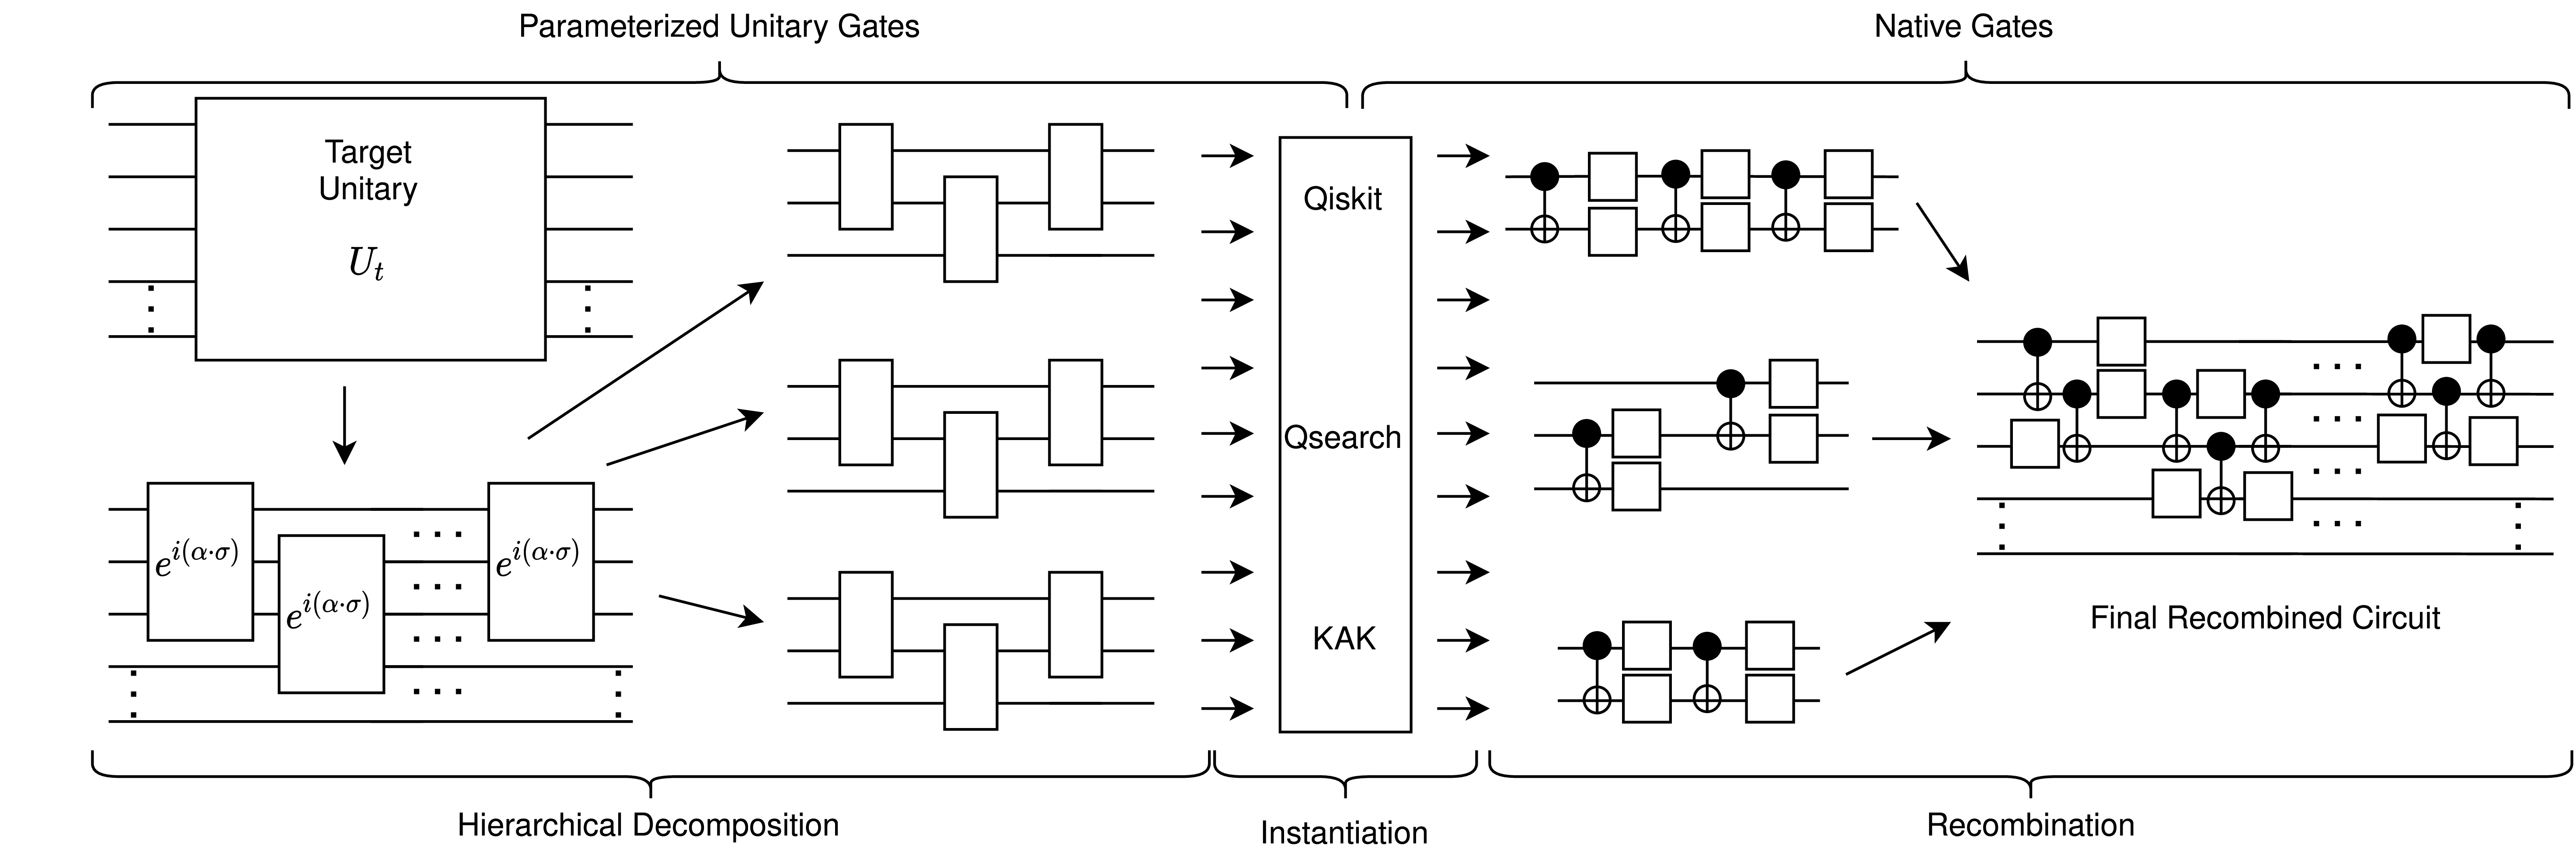

In the first phase, the input unitary
is hierarchically decomposed into smaller unitaries. This decomposition
phase is a form of bottom-up synthesis, where the circuit is built
up one gate at a time without ever backtracking or branching.
This is done using a gate encoding with variable location, which
allows a numerical optimizer to solve for both gate function and
location.

After decomposition, the general unitary gates are converted to
native gates using another synthesis tool. Finally, the circuit
is recombined and returned.

Like bottom-up, search-based synthesis algorithms, QFAST is topology-aware
and portable. It's topology-aware since the set of valid locations,
determined by hardware topology, can be encoded. Also, since QFAST uses
other tools to do the final conversion it is portable as long
as the other synthesis tool is portable.

### BQSKit Implementations

BQSKit implements only the QFAST Decomposition phase unlike the original prototype of QFAST that performs all
three phases. In BQSKit the ability to program the compiler flow, combined with access to the entire suite of
supported algorithms, enables greater flexibility in a QFAST flow.

1) Let's start with a simple example using QSearch off-the-shelf to synthesize a toffoli circuit:

In [1]:
from bqskit.ir.circuit import Circuit
from bqskit.compiler import Compiler
from bqskit.qis.unitary import UnitaryMatrix
from bqskit.passes import QFASTDecompositionPass

# Encode the toffoli unitary
toffoli_unitary = UnitaryMatrix([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0],
])

# Inputs to the BQSKit compiler must be a circuit
# So first we place the toffoli unitary into a circuit
# Note: NumPy arrays are interchangable with UnitaryMatrix objects
circuit = Circuit.from_unitary(toffoli_unitary)

# We must now tell the compiler that we would like to execute QFAST
# This is done by passing the circuit as the input and only a QFASTDecompositionPass
# object in the workflow.
# Finally, we construct a compiler and pass the circuit and workflow to it.
with Compiler() as compiler:
    synthesized_circuit = compiler.compile(circuit, QFASTDecompositionPass())

for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

PauliGate(2) Count: 6


Notice the resulting circuit is composed of `PauliGate`s, an encoding of a general unitary gate.
To go all the way to native gates, QFAST needs to be followed by another synthesis tool.
In the below example after QFAST is called, each block is synthesized with QSearch:

In [2]:
from bqskit.passes import ForEachBlockPass
from bqskit.passes import QSearchSynthesisPass
from bqskit.passes import UnfoldPass

# ForEachBlockPass will run it's argument passes on each block
# The UnfoldPass will then unroll the synthesized blocks
# Without the unfold pass, the synthesized blocks will
# still be grouped
# Finally, we construct a compiler and pass the circuit and
# workflow to it.
with Compiler() as compiler:
    synthesized_circuit = compiler.compile(
        circuit, [
            QFASTDecompositionPass(),
            ForEachBlockPass([QSearchSynthesisPass()]),
            UnfoldPass(),
        ]
    )

for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

CNOTGate Count: 15
RZGate Count: 15
U3Gate Count: 12
RYGate Count: 30
RXGate Count: 15


One easy optimization that can lead to shorter circuits with little cost is the `ScanningGateRemovalPass`. This pass will attempt to remove gates one-by-one, and is often successful with QFAST.

**Exercise:** Try to place the `ScanningGateRemovalPass` in different parts of the compilation flow. How many place where you successfully able to place a `ScanningGateRemovalPass`?

In [3]:
from bqskit.passes import ScanningGateRemovalPass


# Construct a compiler and pass the circuit and workflow to it.
with Compiler() as compiler:
    synthesized_circuit = compiler.compile(
        circuit, [
            QFASTDecompositionPass(),
            ForEachBlockPass([QSearchSynthesisPass()]),
            UnfoldPass(),
            ScanningGateRemovalPass(),
        ]
    )

for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

CNOTGate Count: 8
RZGate Count: 4
U3Gate Count: 2
RYGate Count: 10
RXGate Count: 2


## Accuracy

Similar to QSearch and LEAP, the `success_threshold` parameter can be adjusted to allow for more or less approximation.
It is important to note that QFAST is more numerically unstable than QSearch and LEAP, and as a result, optimization cannot always produce results below a certain threshold.

**Exercise:** Try changing the success threshold in the following example. What do you expect will happen? Note that both `QSearchSynthesisPass` and `ScanningGateRemovalPass` also have `success_threshold` parameters. Try adjusting all of them.

In [4]:
# We can increase the success threshold allowing for greater error in the result
# Note 1e-1 is a very high error
configured_qfast_pass = QFASTDecompositionPass(success_threshold=1e-1)

with Compiler() as compiler:
    synthesized_circuit = compiler.compile(
        circuit,
        [
            configured_qfast_pass,
            ForEachBlockPass([QSearchSynthesisPass()]),
            UnfoldPass(),
            ScanningGateRemovalPass(),
        ]
    )

for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

out_utry = synthesized_circuit.get_unitary()
print("New Circuit Error:", out_utry.get_distance_from(toffoli_unitary))

CNOTGate Count: 10
RZGate Count: 10
U3Gate Count: 8
RYGate Count: 20
RXGate Count: 10
New Circuit Error: 0.3826838460173927


## Model Restrictions

The QFAST algorithm ensures that with each extra gate added the distance to the target decreases by a little amount. This is done to ensure that progress is made; if adding a gate does not reduce the distance sufficiently, then the gate is removed and the valid locations are temporarily restricted. Doing this ensures better quality results when using QFAST, but it can slow down the algorithm by preventing it from reaching deep into the circuit space quickly. With circuits that are expected to be deep, it might be useful to lower the `progress_threshold` or even to disable it by setting it negative.

**Exercise:** Try adjusting the progress_threshold.

In [5]:
configured_qfast_pass = QFASTDecompositionPass(progress_threshold=-1)

with Compiler() as compiler:
    synthesized_circuit = compiler.compile(
        circuit,
        [
            configured_qfast_pass,
            ForEachBlockPass([QSearchSynthesisPass()]),
            UnfoldPass(),
        ]
    )

for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

CNOTGate Count: 18
RZGate Count: 18
U3Gate Count: 12
RYGate Count: 36
RXGate Count: 18


## Function Encoding

While the key idea in the QFAST algorithm is using a variable location encoding of a gate,
the gate's function still needs to be encoded as well.
The original algorithm uses an expressive general unitary gate encoded in a `PauliGate`,
but this can be changed entirely. By default, a 2-qubit PauliGate is used. The size of the
`PauliGate` can be changed, or the gate can be swapped out for something else. Keep in mind,
that the gate will need be to universal.

**Exercise:** Try adjusting the gate QFAST uses to encode function in the below example:

In [6]:
from bqskit.ir.gates import CYGate
from bqskit.ir.gates import U3Gate
from bqskit.ir.gates import CircuitGate

# We will group together a few gates in  side of a CircuitGate
# We can then pass the group into QFAST
gate_group = Circuit(2)
gate_group.append_gate(CYGate(), (0, 1))
gate_group.append_gate(U3Gate(), 0)
gate_group.append_gate(U3Gate(), 1)
grouped_gate = CircuitGate(gate_group)

configured_qfast_pass = QFASTDecompositionPass(gate=grouped_gate)

# Create and execute a compilation task
with Compiler() as compiler:
    synthesized_circuit = compiler.compile(
        circuit,
        [
            configured_qfast_pass,
            UnfoldPass()
        ]
    )

for gate in synthesized_circuit.gate_set:
    print(f"{gate} Count:", synthesized_circuit.count(gate))

CYGate Count: 11
U3Gate Count: 22


Note that when we use native gates directly, we do not need QSearch inside of a `ForEachBlockPass`.

## Putting It Together

**Exercise:** Three unitaries of different sizes are hardcoded below. Try experiment with different configurations of QFAST. Some general tips:

- Larger blocks, e.g. `PauliGate(3)`, will usually converge quicker but produce longer circuits
- Less expressive gates will usually converge slower but produce better circuits
- Lowering `progress_threshold` and raising `success_threshold` will speed up synthesis
- If you want the best results, it will take experimentation

In [7]:
from bqskit.ir.gates import PauliGate
import math

# Three qubit fredkin or Controlled-Swap gate
fredkin_unitary = UnitaryMatrix([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
])

# X-Gate with three controls (CCCX)
cccx_unitary = UnitaryMatrix([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
])

# An XXXXX(np.pi/4) rotation
xxxxx_unitary = PauliGate(5).get_unitary([math.pi/4 if i == 341 else 0 for i in range(4**5)])

In [8]:
# Change this to other unitaries
circuit = Circuit.from_unitary(fredkin_unitary)

# TODO: build your own compiler task
# with Compiler() as compiler:
#     synthesized_circuit = compiler.compile(circuit,)

# for gate in synthesized_circuit.gate_set:
#     print(f"{gate} Count:", synthesized_circuit.count(gate))